## Ola Bike Ride Request Forecast

1. Installing Required Libraries

In [1]:
%pip install seaborn
%pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

<ipython-input-1-72db84a188ac>:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


2. Reading the Dataset

In [2]:
df = pd.read_csv('ola.csv')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


3. Inspecting the Dataset Shape

In [3]:
df.shape

(10886, 12)

4. Checking Data Types and Missing Values

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 978.1+ KB


5. Descriptive Statistics

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.506614,1.116174,1.00,2.0000,3.000,4.0000,4.0000
holiday,10886.0,0.028569,0.166599,0.00,0.0000,0.000,0.0000,1.0000
workingday,10886.0,0.680875,0.466159,0.00,0.0000,1.000,1.0000,1.0000
weather,10886.0,1.418427,0.633839,1.00,1.0000,1.000,2.0000,4.0000
temp,10886.0,20.230860,7.791590,0.82,13.9400,20.500,26.2400,41.0000
atemp,10886.0,23.655084,8.474601,0.76,16.6650,24.240,31.0600,45.4550
humidity,10886.0,61.886460,19.245033,0.00,47.0000,62.000,77.0000,100.0000
windspeed,10886.0,12.799395,8.164537,0.00,7.0015,12.998,16.9979,56.9969
casual,10886.0,36.021955,49.960477,0.00,4.0000,17.000,49.0000,367.0000
registered,10886.0,155.552177,151.039033,0.00,36.0000,118.000,222.0000,886.0000


6. Splitting the Datetime Column

In [6]:
parts = df["datetime"].str.split(" ", n=2, expand=True)
df["date"] = parts[0]
df["time"] = parts[1].str[:2].astype('int')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4


7. Extracting Day, Month, and Year

In [7]:
parts = df["date"].str.split("-", n=3, expand=True)
df["day"] = parts[0].astype('int')
df["month"] = parts[1].astype('int')
df["year"] = parts[2].astype('int')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,day,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0,2011,1,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1,2011,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2,2011,1,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3,2011,1,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4,2011,1,1


8. Identifying Weekdays or Weekends

In [8]:
from datetime import datetime
import calendar

def weekend_or_weekday(year, month, day):

    if not 1 <= day <= calendar.monthrange(year, month)[1]:
        return -1

    d = datetime(year, month, day)
    if d.weekday() > 4:
        return 0
    else:
        return 1

df['weekday'] = df.apply(lambda x:
                         weekend_or_weekday(x['year'],
                                            x['month'],
                                            x['day']),
                         axis=1)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,day,month,year,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0,2011,1,1,-1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1,2011,1,1,-1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2,2011,1,1,-1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3,2011,1,1,-1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4,2011,1,1,-1


9. Determining AM or PM

In [9]:
def am_or_pm(x):
    if x > 11:
      return 1
    else:
      return 0

df["am_or_pm"] = df["time"].apply(am_or_pm)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,day,month,year,weekday,am_or_pm
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0,2011,1,1,-1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1,2011,1,1,-1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2,2011,1,1,-1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3,2011,1,1,-1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4,2011,1,1,-1,0


10. Dropping Unnecessary Columns

In [10]:
%pip install holidays

In [11]:
from datetime import date
import holidays

def is_holiday(x):

    india_holidays = holidays.country_holidays('IN')


    if india_holidays.get(x):
      return 1
    else:
      return 0

df['holiday'] = df['date'].apply(is_holiday)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,time,day,month,year,weekday,am_or_pm
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,0,2011,1,1,-1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01,1,2011,1,1,-1,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01,2,2011,1,1,-1,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01,3,2011,1,1,-1,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01,4,2011,1,1,-1,0


In [12]:
df.drop(['datetime', 'date'],
        axis=1,
        inplace=True)

11. Checking for Missing Values Again

In [13]:
df.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
time          0
day           0
month         0
year          0
weekday       0
am_or_pm      0
dtype: int64

12. Visualizing Relationships Between Features and Count

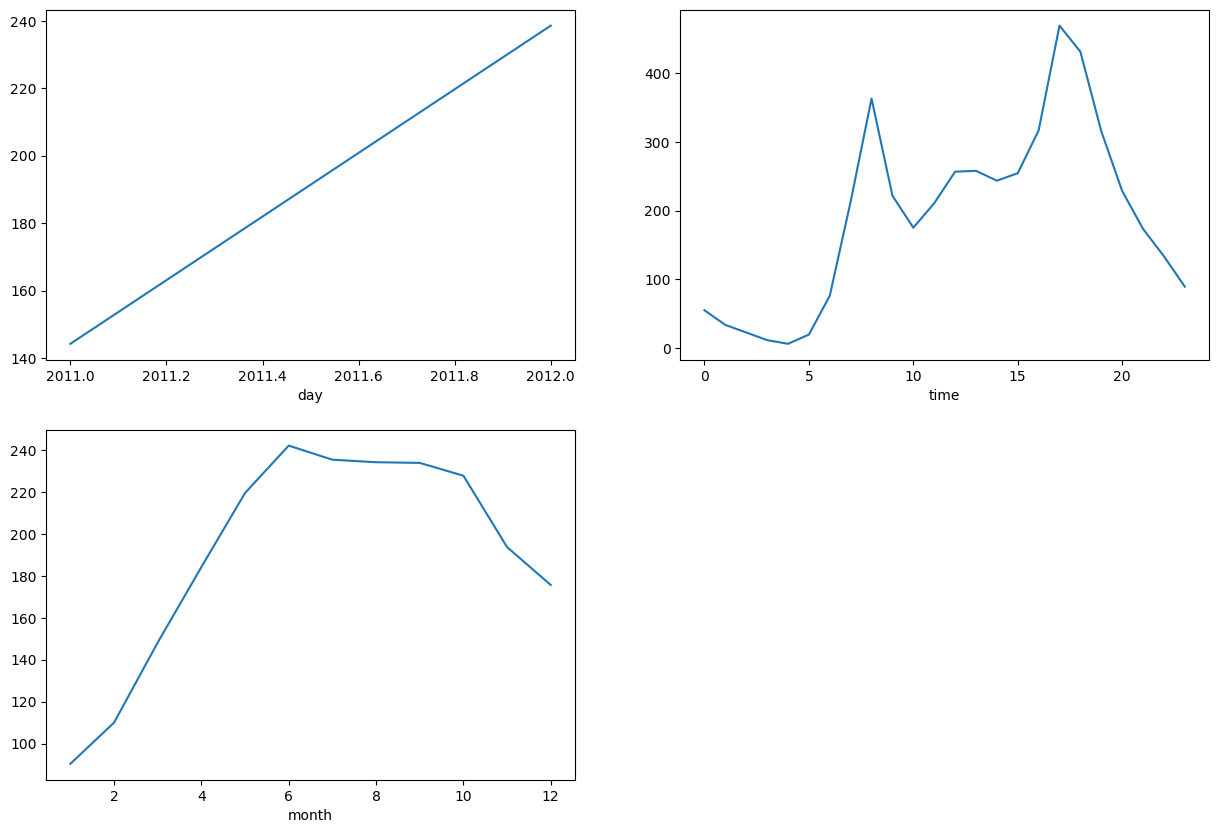

In [14]:
features = ['day', 'time', 'month']

plt.subplots(figsize=(15, 10))
for i, col in enumerate(features):
    plt.subplot(2, 2, i + 1)
    df.groupby(col).mean()['count'].plot()
plt.show()

13. Visualizing Categorical Features

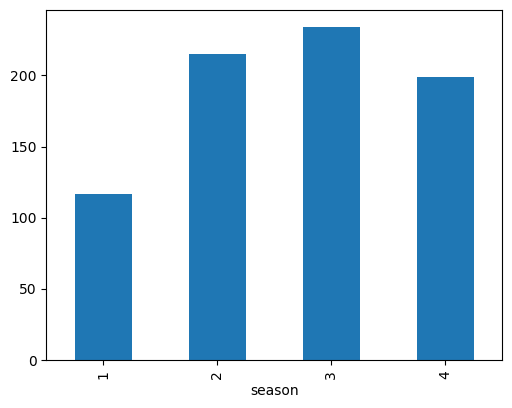

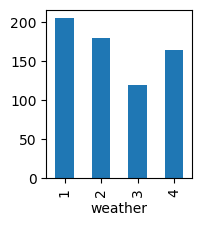

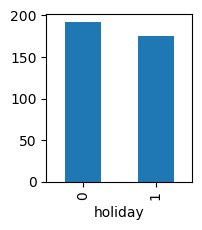

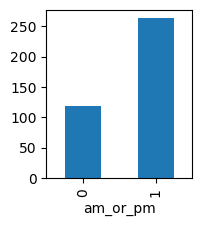

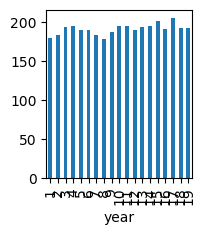

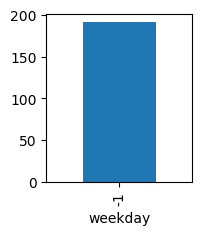

In [15]:
features = ['season', 'weather', 'holiday',\
            'am_or_pm','year', 'weekday']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2, 3, i+1)
  df.groupby(col).mean()['count'].plot.bar()
  plt.show()

14. Visualizing Distribution of Continuous Features

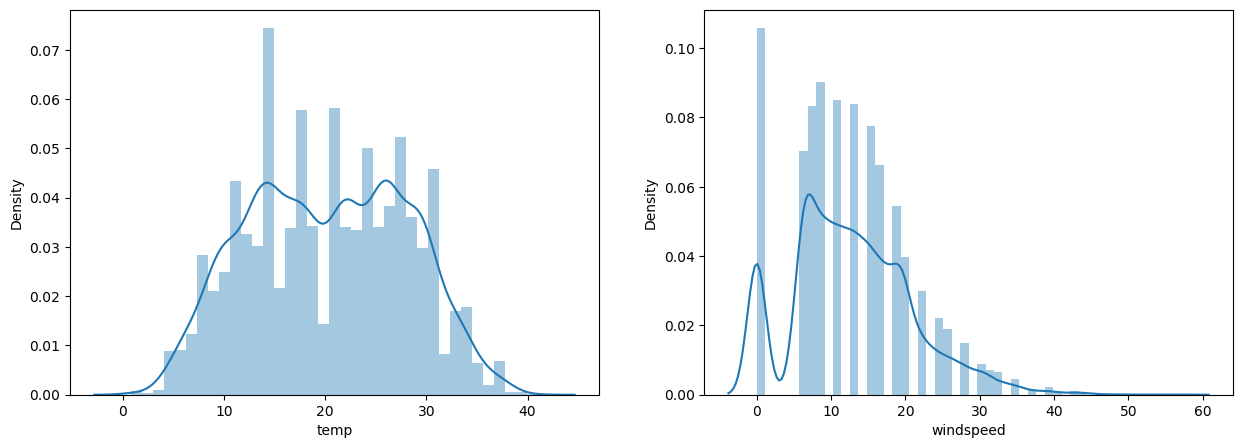

In [16]:
features = ['temp', 'windspeed']

plt.subplots(figsize=(15,5))
for i, col in enumerate(features):
  plt.subplot(1, 2, i+1)
  sb.distplot(df[col])

plt.show()

15. Boxplot to Detect Outliers

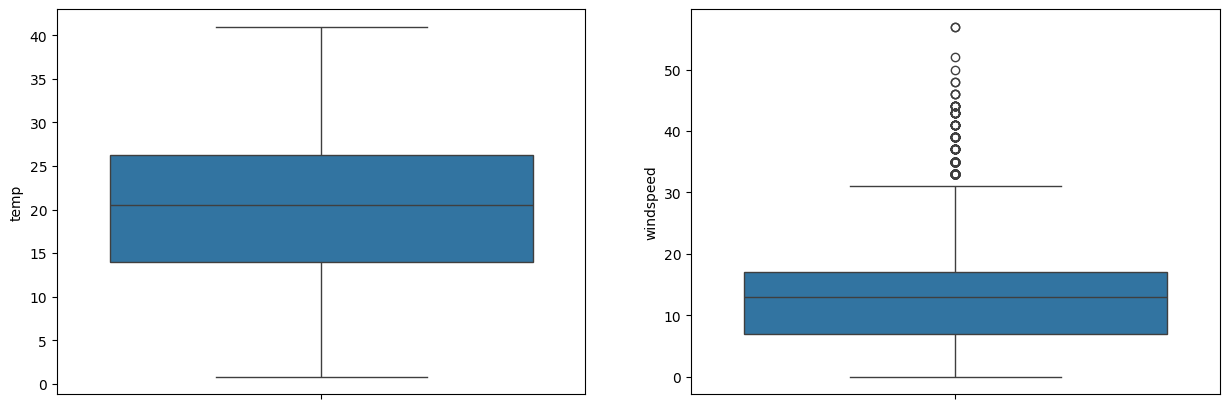

In [17]:
features = ['temp', 'windspeed']

plt.subplots(figsize=(15,5))
for i, col in enumerate(features):
  plt.subplot(1, 2, i+1)
  sb.boxplot(df[col])

plt.show()

16. Calculating the Impact of Removing Outliers

In [18]:
num_rows = df.shape[0] - df[df['windspeed']<32].shape[0]
print(f'Number of rows that will be lost if we remove outliers is equal to {num_rows}.')

Number of rows that will be lost if we remove outliers is equal to 227.


17. Boxplot for humidity, casual, registered, and count

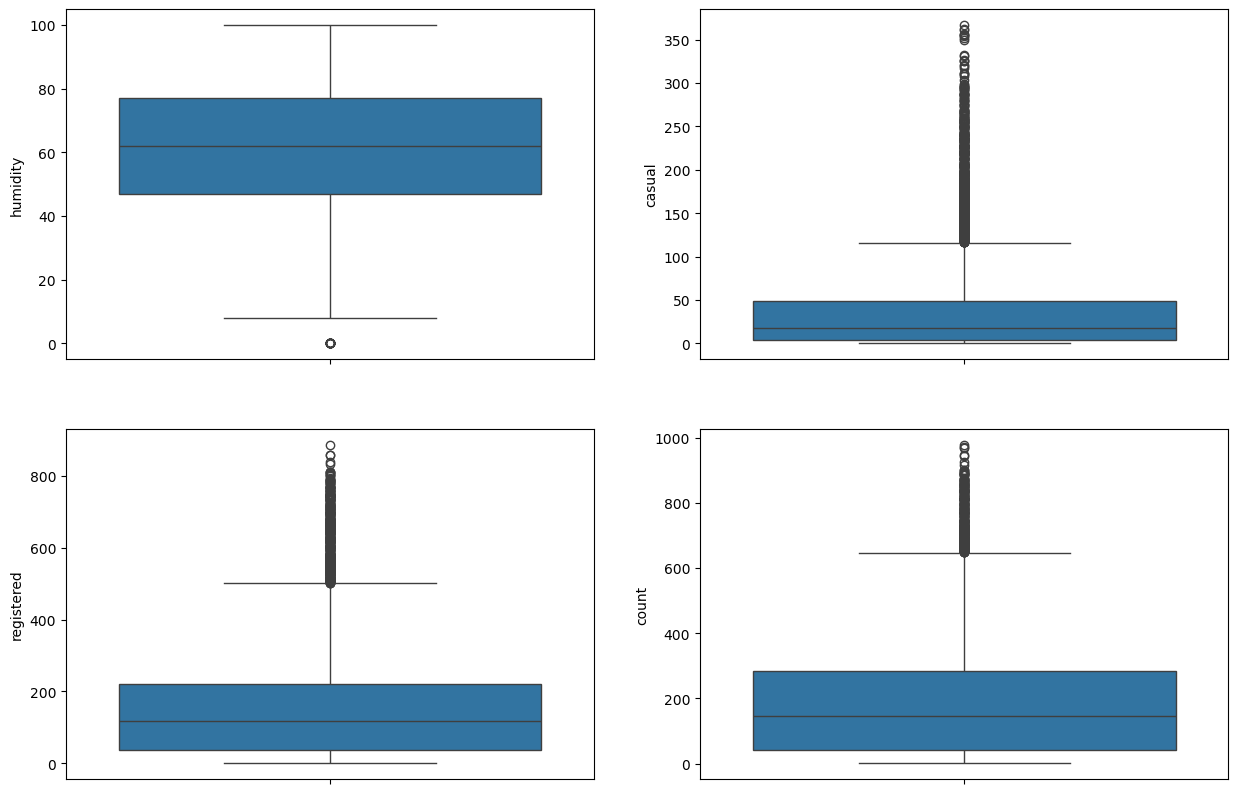

In [19]:
features = ['humidity', 'casual' , 'registered', 'count']

plt.subplots(figsize=(15,10))
for i, col in enumerate(features):
  plt.subplot(2, 2, i+1)
  sb.boxplot(df[col])
plt.show()

18. Correlation Heatmap

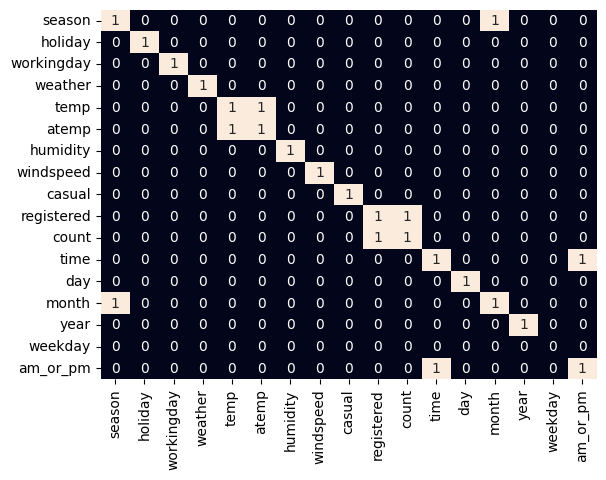

In [20]:
sb.heatmap(df.corr() > 0.8 ,
           annot=True,
           cbar=False)
plt.show()

19. Dropping Columns and Handling Outliers

In [21]:
df.drop(['registered', 'time'], axis=1, inplace=True)
df = df[(df['windspeed'] < 32) & (df['humidity'] >0 )]

20. Preparing Data for Model Training

In [27]:
features = df.drop(['count'], axis=1)
target = df['count'].values

X_train, X_val, Y_train, Y_val = train_test_split(features, target,test_size=0.15, random_state=42)
X_train.shape, X_val.shape

((9042, 14), (1596, 14))

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

21. Training Multiple Models

In [29]:
models = [
    LinearRegression(),
    XGBRegressor(),
    Lasso(),
    RandomForestRegressor(),
    Ridge()
]
for model in models:
    model.fit(X_train, Y_train)
    predictions = model.predict(X_val)
    r2 = metrics.r2_score(Y_val, predictions)
    mse = metrics.mean_squared_error(Y_val, predictions)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(Y_val, predictions)
    print(f"Model: {model.__class__.__name__}")
    print(f"R^2 score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print("-" * 50)

Model: LinearRegression
R^2 score: 0.5964
Mean Squared Error: 13733.5020
Root Mean Squared Error: 117.1900
Mean Absolute Error: 82.9779
--------------------------------------------------
Model: XGBRegressor
R^2 score: 0.7344
Mean Squared Error: 9039.6851
Root Mean Squared Error: 95.0773
Mean Absolute Error: 61.7298
--------------------------------------------------
Model: Lasso
R^2 score: 0.5957
Mean Squared Error: 13756.8901
Root Mean Squared Error: 117.2898
Mean Absolute Error: 82.6526
--------------------------------------------------
Model: RandomForestRegressor
R^2 score: 0.7466
Mean Squared Error: 8623.6414
Root Mean Squared Error: 92.8636
Mean Absolute Error: 60.0231
--------------------------------------------------
Model: Ridge
R^2 score: 0.5964
Mean Squared Error: 13733.6528
Root Mean Squared Error: 117.1907
Mean Absolute Error: 82.9768
--------------------------------------------------


22.  Model visualizations

In [30]:
model_names = []
r2_scores = []
mse_scores = []
rmse_scores = []
mae_scores = []

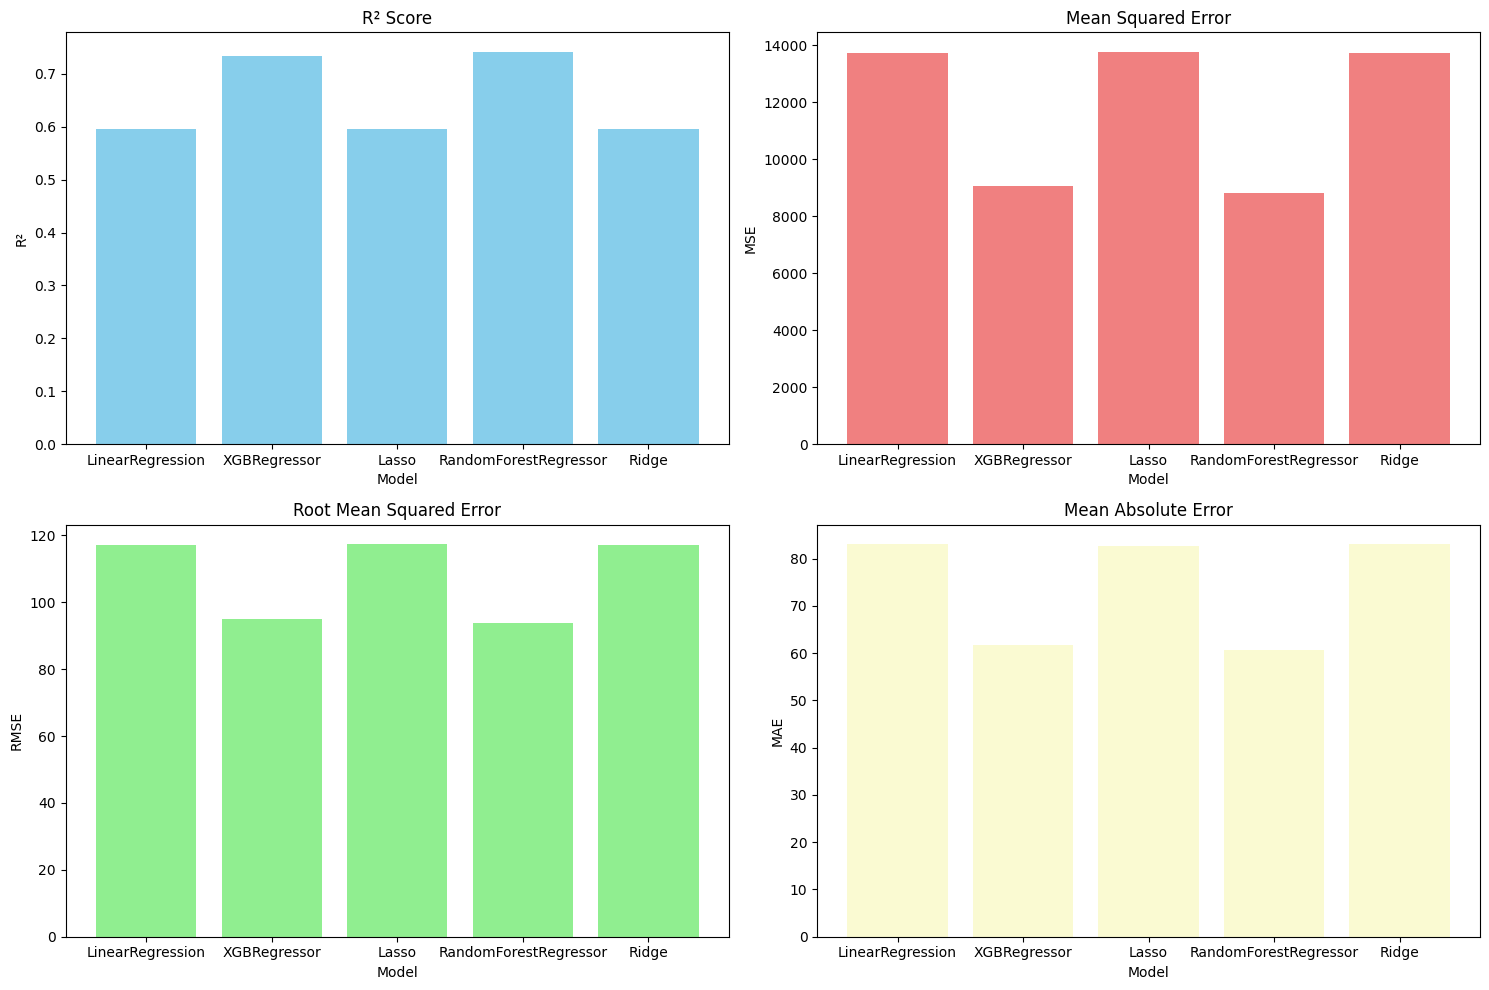

In [31]:
for model in models:
    model.fit(X_train, Y_train)
    predictions = model.predict(X_val)
    
    r2 = metrics.r2_score(Y_val, predictions)
    mse = metrics.mean_squared_error(Y_val, predictions)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(Y_val, predictions)
    
    model_names.append(model.__class__.__name__)
    r2_scores.append(r2)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    
    mae_scores.append(mae)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].bar(model_names, r2_scores, color='skyblue')
ax[0, 0].set_title('R² Score')
ax[0, 0].set_xlabel('Model')
ax[0, 0].set_ylabel('R²')

ax[0, 1].bar(model_names, mse_scores, color='lightcoral')
ax[0, 1].set_title('Mean Squared Error')
ax[0, 1].set_xlabel('Model')
ax[0, 1].set_ylabel('MSE')


ax[1, 0].bar(model_names, rmse_scores, color='lightgreen')
ax[1, 0].set_title('Root Mean Squared Error')
ax[1, 0].set_xlabel('Model')
ax[1, 0].set_ylabel('RMSE')

ax[1, 1].bar(model_names, mae_scores, color='lightgoldenrodyellow')
ax[1, 1].set_title('Mean Absolute Error')
ax[1, 1].set_xlabel('Model')
ax[1, 1].set_ylabel('MAE')

plt.tight_layout()
plt.show()

The predictions made by the RandomForestRegressor are really amazing compared to the other model. In the case of RandomForestRegressor, there is a little bit of overfitting but we can manage it by hyperparameter tuning.